<a href="https://colab.research.google.com/github/markqian359/APS360/blob/labs/APS360_Lab3_Zhiwei_Qian_1002934346.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3b: Gesture Recognition using Convolutional Neural Networks
Zhiwei Qian 1002934346 blahblahblah


## Colab Link

Include a link to your colab file here

Colab Link: 

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

The splitting strategy I used was to shuffle and split all indices.
Based on the results, the number of training, validation and test images are illustrated below:
*   Training images: 1458
*   Validation images: 486
*   Test images: 487





In [ ]:
#import all libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [ ]:
import io
from google.colab import files
files.upload()
!unzip "/content/Lab_3_Gesture_Dataset.zip"

Saving Lab_3_Gesture_Dataset.zip to Lab_3_Gesture_Dataset.zip
Archive:  /content/Lab_3_Gesture_Dataset.zip
   creating: Lab_3b_Gesture_Dataset/A/
  inflating: Lab_3b_Gesture_Dataset/A/1_A_1.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/1_A_2.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/1_A_3.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/10_A_1.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/10_A_2.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/10_A_3.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/100_A_1.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/100_A_2.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/100_A_3.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/101_A_1.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/101_A_2.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/101_A_3.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/102_A_1.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/102_A_2.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/102_A_3.jpg  
  inflating: Lab_3b_Gesture_Dataset/A/11_A_1.jpg  
  inflating: Lab_3b_Gesture_Data

In [ ]:
imgdata = torchvision.datasets.ImageFolder('/content/Lab_3b_Gesture_Dataset')

In [ ]:
def split_data(dataset, classes, batch_size, num_workers):
    indices = []
    for i in range(len(dataset)):
        indices.append(i)
    
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(indices)
    split_train = int(len(indices) * 0.6)
    split_val = int(len(indices) * 0.2)

    relevant_train_indices, relevant_val_indices, relevant_test_indices = indices[:split_train], indices[split_train:split_train+split_val], indices[split_train+split_val:] 

    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_sampler)

    return train_loader, val_loader, test_loader

In [ ]:
def get_data_loader(classes, batch_size, num_workers):
    # location on google colab
    gesture_path = '/content/Lab_3b_Gesture_Dataset'

    # Transform Settings - Do not use RandomResizedCrop
    transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

    # Load data from google colab
    dataset = torchvision.datasets.ImageFolder(gesture_path, transform=transform)   

    # Prepare Dataloader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    train_loader, val_loader, test_loader = split_data(dataset, classes, batch_size, num_workers)
    
    return data_loader, train_loader, val_loader, test_loader

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

Number of Training Data:  1458 
 Number of Validation Data:  486 
 Number of Test Data:  487


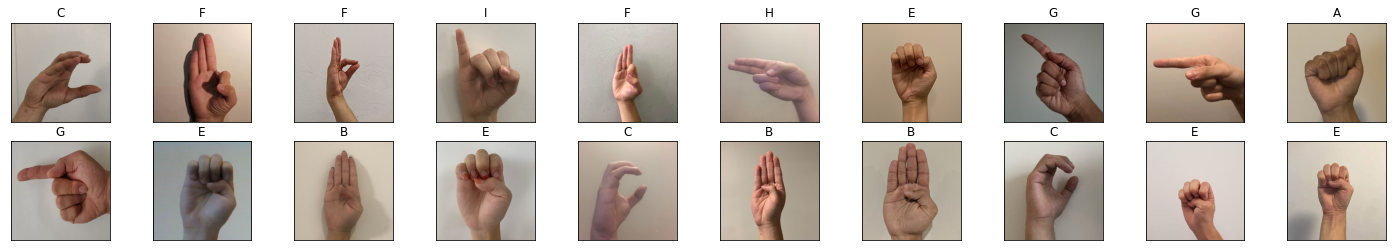

In [ ]:
# Loading Gesture Images from Google Drive
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 27
num_workers = 1

data_loader, train_loader, val_loader, test_loader = get_data_loader(classes, batch_size, num_workers)

# Size of Training, Validation, Test Dataset
print("Number of Training Data: ", len(train_loader.sampler), '\n',
   "Number of Validation Data: ", len(val_loader.sampler), '\n',
   "Number of Test Data: ", len(test_loader.sampler))

# Verification Step - obtain one batch of images
dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

For the neural network architecture, all the features are described below:
*   Numbers and types of layers: 2 convolutional and 2 fully connected
*   Pooling layers: two 2x2 max pooling layers
*   Type of activation function: ReLU
*   Number of input channels: 3
*   Number of output channels for 1st convolutional layer: 5
*   Number of output channels for 2nd convolutional layer: 10
*   Number of hidden units: 32
*   Number of outputs: 9







In [ ]:
torch.manual_seed(1000) # set the random seed
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "default"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

The loss function used is cross entropy which is commonly used in classification problems. The output is normalized into a probability value between 0 and 1. 

The optimizer used is Adam Optimizer which incorporates momentum, adaptive learning rate, and SGD. By using the optimizer, the model is able to converge faster with minimal tuning.

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

In [ ]:
def train(model, classes, batch_size, num_epochs, learn_rate):

    torch.manual_seed(1000)
    data_loader, train_loader, val_loader, test_loader = get_data_loader(classes, batch_size, num_workers=1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    iters, epochs, losses, train_loss, train_acc, val_acc = [], [],[],[],[],[]
    total_loss = 0.0
    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels)      # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()            # a clean up step for PyTorch
            
        
            # track average loss of each iteration
            iters.append(n)
            losses.append(float(loss)/batch_size)
            total_loss += float(loss)
            n += 1

        epochs.append(epoch)
        train_loss.append(total_loss)
        total_loss = 0.0
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        print(("Epoch {}: Train Accuracy: {}, Validation Accuracy: {}, Total Train Loss: {}, ").format(epoch, train_acc[-1], val_acc[-1], train_loss[-1]))

        
      
    # plotting
    plt.title("Training Loss Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learn_rate, num_epochs)
    path = F"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab3_2b/{model_path}"
    torch.save(model.state_dict(), path)  
        
    return

  

In [ ]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 27
num_epochs = 5
learn_rate = 0.01

use_cuda = True

cnn = CNNClassifier()

if use_cuda and torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(cnn,classes, batch_size, num_epochs, learn_rate)


### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
# default number of hidden units
class midCNN(nn.Module):
    def __init__(self):
        super(midCNN, self).__init__()
        self.name = "mid"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# large number of hidden units
class largeCNN(nn.Module):
    def __init__(self):
        super(largeCNN, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(10 * 53 * 53, 64)
        self.fc2 = nn.Linear(64, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# small number of hidden units
class smallCNN(nn.Module):
    def __init__(self):
        super(smallCNN, self).__init__()
        self.name = "small"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(10 * 53 * 53, 16)
        self.fc2 = nn.Linear(16, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# combination 1
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 27
num_epochs = 20
learn_rate = 0.001
cnn = midCNN()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(cnn,classes, batch_size, num_epochs, learn_rate)

In [ ]:
# combination 2
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 64
num_epochs = 20
learn_rate = 0.001
cnn = midCNN()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(cnn,classes, batch_size, num_epochs, learn_rate)

In [ ]:
# combination 3
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 128
num_epochs = 20
learn_rate = 0.001
cnn = midCNN()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(cnn,classes, batch_size, num_epochs, learn_rate)

In [ ]:
# combination 4
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 64
num_epochs = 15
learn_rate = 0.001
cnn = largeCNN()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(cnn,classes, batch_size, num_epochs, learn_rate)

In [ ]:
# combination 5
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 64
num_epochs = 20
learn_rate = 0.001
cnn = smallCNN()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(cnn,classes, batch_size, num_epochs, learn_rate)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 64
num_epochs = 20
model = midCNN()

model_path = get_model_name(model.name, batch_size, 0.001, num_epochs)
path = "/content/gdrive/My Drive/Colab Notebooks/APS360/Lab 3/model/{}".format(model_path)
state = torch.load(path)
model.load_state_dict(state)

data_loader, train_loader, val_loader, test_loader = get_data_loader(classes, batch_size, num_workers=1)

In [ ]:
correct = 0
total = 0
for imgs, labels in test_loader:
    output = model(imgs)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
test_acc = correct / total

print("Test Accuracy: {}".format(test_acc))

Test Accuracy: 0.7186858316221766


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
# Save Features to Folder (assumes code from 1. has been evaluated)

import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# location on Google Drive
master_path = '/content/gdrive/My Drive/Colab Notebooks/APS360/Lab 3/Features'

# prepare dataloader
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 1
data_loader, train_loader, val_loader, test_loader = get_data_loader(classes, batch_size, num_workers=1)

# save features to folder as tensors
# train features
n = 0
for imgs, labels in iter(train_loader):
    train_features = alexnet.features(imgs)
    train_features_tensor = torch.from_numpy(train_features.detach().numpy())
    folder_name = master_path + '/' + 'train' + '/' + str(classes[labels])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(train_features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

# validation features
n = 0
for imgs, labels in iter(val_loader):
    val_features = alexnet.features(imgs)
    val_features_tensor = torch.from_numpy(val_features.detach().numpy())
    folder_name = master_path + '/' + 'val' + '/' + str(classes[labels])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(val_features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1


# test features
n = 0
for imgs, labels in iter(test_loader):
    test_features = alexnet.features(imgs)
    test_features_tensor = torch.from_numpy(test_features.detach().numpy())
    folder_name = master_path + '/' + 'test' + '/' + str(classes[labels])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(test_features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1


In [ ]:
# Load Tensor Files (features) from folder

# load features
# location on Google Drive
master_path = '/content/gdrive/My Drive/Colab Notebooks/APS360/Lab 3/Features/'
train_set = torchvision.datasets.DatasetFolder(master_path + 'train', loader=torch.load, extensions=('.tensor'))
val_set = torchvision.datasets.DatasetFolder(master_path + 'val', loader=torch.load, extensions=('.tensor'))
test_set = torchvision.datasets.DatasetFolder(master_path + 'test', loader=torch.load, extensions=('.tensor'))

# Prepare Dataloader
batch_size = 32
num_workers = 1
torch.manual_seed(1000)
train_feature_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_feature_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_feature_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(train_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([32, 256, 6, 6])
torch.Size([32])


### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

In [ ]:
class alexANN(nn.Module):
    def __init__(self):
        super(alexANN,self).__init__()
        self.name = 'alexnet'
        self.fc1 = nn.Linear(256*6*6,4096) 
        self.fc2 = nn.Linear(4096,9) 

    def forward(self,x): 
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def alex_get_accuracy(model, data_loader):
    correct = 0
    total = 0
    
    for imgs, labels in data_loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

In [ ]:
def alex_train(model, num_epochs=5, learn_rate=0.001):
    #torch.manual_seed(1000)
    #train_loader = get_feature_loader(True, batch_size,  num_workors = 1)
    #val_loader = get_feature_loader(False, batch_size,  num_workors = 1)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), learn_rate)

    iters, epochs, losses, train_loss, train_acc, val_acc = [], [],[],[],[],[]

    # training
    n = 0 # the number of iterations
    total_loss = 0.0
    for epoch in range(num_epochs):
        for imgs, labels in train_feature_loader:
          
            imgs = torch.from_numpy(imgs.detach().numpy())
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)
            total_loss += float(loss)
            n += 1

        epochs.append(epoch)
        train_loss.append(total_loss)
        total_loss = 0.0
        train_acc.append(alex_get_accuracy(model, train_feature_loader))
        val_acc.append(alex_get_accuracy(model, val_feature_loader))
        print(("Epoch {}: Train Accuracy: {}, Validation Accuracy: {}, Total Train Loss: {}, ").format(epoch, train_acc[-1], val_acc[-1], train_loss[-1]))


    # plotting
    plt.title("Training Loss Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learn_rate, num_epochs)
    path = F"/content/gdrive/My Drive/Colab Notebooks/APS360/Lab 3/model/{model_path}"
    torch.save(model.state_dict(), path)  
        



### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())

In [ ]:
use_cuda = True
alex = alexANN()

if use_cuda and torch.cuda.is_available():
  alex.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


alex_train(alex, num_epochs=20, learn_rate=0.001)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
batch_size = 32
num_epochs = 20
model = alexCNN()

model_path = get_model_name(model.name, batch_size, 0.001, num_epochs)
path = "/content/gdrive/My Drive/Colab Notebooks/APS360/Lab 3/model/{}".format(model_path)
state = torch.load(path)
model.load_state_dict(state)

correct = 0
total = 0
for imgs, labels in test_feature_loader:
    output = model(imgs)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
test_acc = correct / total

print("Test Accuracy: {}".format(test_acc))

Test Accuracy: 0.9527720739219713


### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?